In [1]:
# @title Скачиваем архив из сети и распаковываем в менеждер файлов сессии колаб
!wget --user anonymous --password anonymous https://aldanstar.keenetic.pro/webdav/Petropyths/3259.zip
!wget --user anonymous --password anonymous https://aldanstar.keenetic.pro/webdav/Petropyths/3259.xlsx
!unzip "/content/3259.zip"

!wget --user anonymous --password anonymous https://aldanstar.keenetic.pro/webdav/Petropyths/grain_data.zip
!unzip "/content/grain_data.zip"

!wget --user anonymous --password anonymous https://aldanstar.keenetic.pro/webdav/Petropyths/3_1060-Average.xls

!wget --user anonymous --password anonymous https://aldanstar.keenetic.pro/webdav/Petropyths/SHEPARD.npz

--2025-05-29 15:47:05--  https://aldanstar.keenetic.pro/webdav/Petropyths/3259.zip
Resolving aldanstar.keenetic.pro (aldanstar.keenetic.pro)... 185.162.93.96, 95.213.212.50
Connecting to aldanstar.keenetic.pro (aldanstar.keenetic.pro)|185.162.93.96|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="Keenetic Giga"
Reusing existing connection to aldanstar.keenetic.pro:443.
HTTP request sent, awaiting response... 200 OK
Length: 1087682 (1.0M) [application/zip]
Saving to: ‘3259.zip’

3259.zip            100%[===================>]   1.04M   792KB/s    in 1.3s    

2025-05-29 15:47:09 (792 KB/s) - ‘3259.zip’ saved [1087682/1087682]

--2025-05-29 15:47:09--  https://aldanstar.keenetic.pro/webdav/Petropyths/3259.xlsx
Resolving aldanstar.keenetic.pro (aldanstar.keenetic.pro)... 185.162.93.96, 95.213.212.50
Connecting to aldanstar.keenetic.pro (aldanstar.keenetic.pro)|185.162.93.96|:443... connected.
HTTP request sent, awaiting respo

In [2]:
# @title Библиотеки, которые нам понадобятся. Скачиваем и импортируем в среду
!pip install xlsxwriter # Доустанавливаем библиотеку для записи и оформления Excel. Это врайтер для pd.to_excel
!pip install pint # Для работы с еденицами измерения
!pip install pint_pandas # Для работы с еденицами измерения в пандас

import os
import re
import itertools
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np

import xlsxwriter
from xlsxwriter.utility import xl_rowcol_to_cell, xl_col_to_name,xl_range # Для конвертации цифровых индексов в буквенные
from openpyxl import load_workbook

import pint # Для работы с еденицами измерения
import pint_pandas # Для работы с еденицами измерения в пандас
ureg = pint.UnitRegistry() # Для работы с еденицами измерения
ureg.Unit.default_format = "~P" # Для работы с еденицами измерения
pint_pandas.PintType.ureg.default_format = "~P" # Для работы с еденицами измерения в пандас

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.6 MB/s eta 0:00:00


# Универсальные функции

In [3]:
# @title Для работы с классифкаиорами для диаграмм n-систем
def class_dict_to_array(class_dict:dict, string_length:int = 50)->np.ndarray:
  return np.array(list(class_dict.items()), dtype=[('CODE','u2'),('TYPE',f'U{string_length}')])

def get_class(data:np.ndarray|pd.DataFrame, classifier:str='SHEPARD', show_graph:bool=False, code_indexes:bool = False, class_dict:dict=None, global_path:str = '')->pd.Series:
      '''extension
      По данным массива определяет классификацию

      :data: 2D массив np.ndarray (n,m) или pd.DataFrame где m - это компоненты последоватльно в зависимости от типа классификатора
      :classifier: Тип классификатора или путь к *.npz файлу пользователя:
                "SHEPARD": классификация осадков по содержанию в них глины(аргиллит),песка  и алеврита  (Shерагd. Journ. Seel. Petrol., 24, p. 157, Fig. 7. 1954).
      :show_graph: Расширение файлов (регистронезависимое). По умолчанию False
      :code_indexes: В качестве индексов возвращает коды. По умолчанию False
      :class_dict: Словарь кодов
      :global_path: путь к файлам классификаторам
      :return: Словарь {абсолютный_путь_директории: [список_файлов]}
      '''

      def _array_to_class_dict(class_arr:np.ndarray)->dict:
          return dict(class_arr.tolist())

      def _get_points3(data:np.ndarray, classifier_shape:tuple, param_type:int, show_graph:bool, code_indexes:bool, class_dict:dict)->pd.Series:

            height, width = classifier_shape

            # Расчет координат для треугольной диаграммы
            clay = data[:, 0]
            sand = data[:, 1]
            silt = data[:, 2]

            # Y: от верхней точки (0% глины) к основанию (100% глины)
            Y = (height - 1) * (1 - clay / 100)

            # X: зависит от соотношения песок/алеврит с учетом сужения к вершине
            valid = (sand + silt) > 0
            ratio = np.zeros_like(silt)
            ratio[valid] = silt[valid] / (sand[valid] + silt[valid])

            # Преобразование в координаты треугольника
            X = (ratio * (width - 1) * (1 - clay / 100)) + ((width - 1) * (clay / 100) / 2)

            # Ограничение координат в пределах массива
            Y =  np.clip(Y, 0, height - 1).astype(int)
            X = np.clip(X, 0, width - 1).astype(int)

            return X, Y

      classifier = os.path.join(global_path,f'{classifier}.npz') if len(classifier.split('.'))==1 else classifier
      classifier_arr = np.load(classifier)
      classifier_data = classifier_arr['classifier']
      class_dict = _array_to_class_dict(classifier_arr['attrs']) if class_dict==None else class_dict
      param_count = classifier_arr['params'][0]
      param_type = classifier_arr['params'][1]
      name = classifier_arr['name'][0]
      label = classifier_arr['label'][0]
      function = locals()[f'_get_points{param_count}'] # Получаем локальноую функцию по имени

      height, width = classifier_data.shape  # (3998, 4616) - не обязательно такие размеры, все зависит от выбранной точности при создании файла дискретного классификатора

      data = pd.DataFrame(data)
      data = data.dropna(how='any')

      indexes = data.index
      data = np.asarray(data, dtype=np.float64)

      if len(data.shape)!=2 or data.shape[1]!=param_count: # Провека на соответсвие, что это 2D массив и что количество параметров равно param_count - количества параметров для классификации
        return None

      # Нормализация до 100% (глина, песок, алеврит)
      data = 100 * data / (data.sum(axis=1, keepdims=True) + 1e-10)

      X, Y  = function(data, (height, width),param_type, show_graph, code_indexes, class_dict)

      if show_graph:
          import matplotlib.pyplot as plt
          from matplotlib.patches import Polygon
          plt.figure(figsize=(5, 5))
          ax = plt.axes()
          ax.imshow(classifier_data)

          ax.scatter(X, Y, c='red', s=20, alpha=0.8)
          for i, (txt, idx) in enumerate(zip(np.arange(1,data.shape[0]+1),indexes)):
            plt.annotate(f'{txt}({idx})', (X[i], Y[i]))
          plt.title(name, pad=20)
          labels = list(class_dict.values())

          if param_count==3:
            # Получим текущие оси и нарисуем боковые грани
            axes = plt.gca()
            axes.set_aspect("equal")
            axes.add_patch(Polygon(([width-1,height-1],[(width-1)/2,0], [0,height-1], [0,0],[width-1,0]), alpha=0.8, fc='w'))

            plt.xlabel(f"{labels[2]} ↔ {labels[1]}")
            plt.ylabel(f"{labels[0]}")

          plt.xticks([])
          plt.yticks([])
          plt.show()

      # Получение классов
      classes = classifier_data[Y, X]
      if code_indexes:
        result = pd.Series(class_dict)[classes]
      else:
        result = pd.Series(class_dict)[classes].reset_index(drop=True)
        result.index = indexes
      result.name = label
      return result

In [4]:
# @title Снятие защиты с excel файлов

def unprotect_files(files_path:list|str):
  files_path = files_path if isinstance(files_path, list) else [files_path]
  for sample_path in files_path:
    try:
      if not os.path.exists(sample_path): continue
    except TypeError:
      if sample_path is None: continue
    sample = load_workbook(filename=sample_path)
    for sheet in sample: sheet.protection.disable()
    sample.save(filename=sample_path)
    sample.close()

In [5]:
# @title Поиск файлов

def files_search(path:str, extension:str|list=['xlsx','xls'])->dict:
    """extension
    Собирает файлы с заданным расширением в словарь, где ключи — директории,
    а значения — списки абсолютных путей к файлам.

    Parameters
    ----------
    path str: Начальный путь для поиска
    extension str|list: Расширение файлов (регистронезависимое). По умолчанию ['xlsx','xls']

    Returns
    -------
    dict: Словарь {абсолютный_путь_директории: [список_файлов]}
    """
    def check_extensions(file_name:str, extensions_list:list)->bool:
          '''Локальная функция проверки на соответствие списку расширений'''
          bool_list = [file_name.lower().endswith(f'.{extension}') for extension in extensions_list]
          return any(bool_list)

    file_dict = {}
    target_extensions = [extension.lstrip('.').lower()] if isinstance(extension, str) else [ext.lstrip('.').lower() for ext in extension]  # Удаляем точку и приводим к нижнему регистру
    start_path = os.path.abspath(path)  # Преобразуем в абсолютный путь

    if not os.path.isdir(start_path):
        raise ValueError("Указанный путь не существует или не является директорией")

    for dirpath, _, filenames in os.walk(start_path):
        matched_files = []
        for filename in filenames:
            file_ext = os.path.splitext(filename)[1].lower()  # Расширение файла в нижнем регистре
            if check_extensions(file_ext, target_extensions):
                abs_file_path = os.path.join(dirpath, filename)
                matched_files.append(abs_file_path)

        if matched_files:
            file_dict[os.path.basename(dirpath)] = matched_files  # dirpath уже абсолютный благодаря start_path

    return file_dict

def files_scan(path:str, extension:str|list=['xlsx','xls'])->dict:
    return list(itertools.chain.from_iterable(list(files_search(path, extension=extension).values())))

# Функции обработчика

In [34]:
# @title Парсеры и ридеры

def _unit_by_str(string:str)->str:
  return re.findall('\((.+)\)',string)[0]

def _BettersizerST_parser(file_path:str)->pd.DataFrame:
    '''
    Парсит файлы анализатора Bettersizer ST (Китай) в структурированный DataFrame.

    Параметры
    ----------
    file_path : str
        Путь к файлу Excel с данными прибора

    Возвращает
    -------
    tuple: кортеж из:
        pd.DataFrame
            DataFrame с гранулометрическими данными и метаданными:
            - Столбцы:
              * s(µm): Начало диапазона размера частиц
              * m(µm): Среднее значение диапазона
              * e(µm): Конец диапазона
              * %: Процентное содержание фракции
            - Атрибуты:
              * Метаданные теста в df.attrs
        str: 'µm' - еденицы измерения обработанных данных

    Пример
    --------
    >>> df, unit = BettersizerST_parser('data.xlsx')
    >>> print(df.attrs)  # Метаданные теста
    >>> print(df.head()) # Основные данные

    Примечания
    -----
    1. Обрабатывает файлы формата .xlsx с листом "Test Results"
    2. Автоматически определяет границы диапазонов из колонки "Diam um"
    3. Сохраняет оригинальные метаданные теста в атрибутах DataFrame
    '''
    metadata_df = pd.read_excel(file_path,skiprows=2, nrows=6).dropna(how='all', axis='columns')
    metadata_df.columns=pd.RangeIndex(metadata_df.columns.size)
    metadata_df=pd.DataFrame(metadata_df.apply(lambda x: x.str.split(pat='\D:').explode(ignore_index=True)).T.values.reshape(-1,2)).set_index(0).dropna(how='any', axis='index').T
    metadata_df = metadata_df.loc[:,['  Sample No','  Sample Nam','  Operato','  Test Tim']]
    metadata_df=metadata_df.rename(columns={'  Sample No':'N','  Sample Nam':'Name','  Operato':'Operator','  Test Tim':'DateTime'})
    metadata_df.loc[:,'DateTime'] = pd.to_datetime(metadata_df.loc[:,'DateTime'], format='%Y-%m-%d %H:%M:%S')
    metadata_df['N'] = metadata_df['N'].astype(str)
    metadata_df=metadata_df.set_index('N')
    temp_df = pd.read_excel(file_path,skiprows=15).dropna(how='all', axis='columns').dropna(how='any', axis='index')
    temp_df = pd.DataFrame(temp_df.values.reshape(-1,3),columns = temp_df.columns[:3]).sort_values('Diam um').reset_index(drop=True)
    temp_df = temp_df.rename(columns={'Diff%':'%'})
    result = pd.DataFrame(temp_df.loc[:,'Diam um'].str.split('-').explode()).stack().reset_index()
    result.loc[:,'level_1'] = np.repeat([['s(µm)','e(µm)']],int(result.shape[0]/2), axis=0).ravel()
    result = result.set_index(['level_0',	'level_1']).unstack().rename({0:'Diam um'}, axis='columns')
    result.columns.names=['','']
    result.index.name=''
    result.columns = result.columns.droplevel(0)
    result = result.loc[:,['s(µm)','e(µm)']].astype(np.float64).sort_values('s(µm)')
    result['m(µm)'] = result.loc[:, ['s(µm)','e(µm)']].mean(1)
    result = result.join(temp_df.loc[:,['%']].astype(np.float64))
    del temp_df
    result = result.loc[:,['s(µm)','m(µm)','e(µm)','%']]
    result.attrs['metadata'] = metadata_df
    return result, 'µm'

def _BeckmanCoulterLS13320XR_parser(file_path:str)->pd.DataFrame:
    '''
    Парсит файлы анализатора LS 13 320 XR (Beckman Coulter) в структурированный DataFrame.

    Параметры
    ----------
    file_path : str
        Путь к файлу Excel с данными прибора

    Возвращает
    -------
    tuple: кортеж из:
        pd.DataFrame
            DataFrame с гранулометрическими данными и метаданными:
            - Столбцы:
              * s(µm): Начало диапазона размера частиц
              * m(µm): Среднее значение диапазона
              * e(µm): Конец диапазона
              * %: Усредненное процентное содержание фракции
            - Атрибуты:
              * Метаданные теста в df.attrs
        str: 'µm' - еденицы измерения обработанных данных

    Пример
    --------
    >>> df, unit = BeckmanCoulterLS13320XR_parser('data.xlsx')
    >>> print(df.attrs)  # Метаданные теста
    >>> print(df.head()) # Основные данные

    Примечания
    -----
    1. Обрабатывает файлы формата .xlsx с листом "Size Data"
    2. Рассчитывает границы диапазонов на основе средних значений
    3. Усредняет результаты трех измерений в колонке "%"
    4. Автоматически определяет временную метку теста из метаданных
    '''
    metadata_df = pd.read_excel(file_path,skiprows=4, nrows=7).dropna(how='all', axis='columns').dropna(how='all', axis='index')
    metadata_df = metadata_df.set_index('Unnamed: 1').T
    metadata_df = metadata_df.rename(columns={'Sample Date':'DateTime',	'User':'Operator',	'Sample ID':'N'})
    metadata_df = metadata_df.loc[:,['N','Name','Operator','DateTime']]
    metadata_df.loc[:,'DateTime'] = pd.to_datetime(metadata_df.loc[:,'DateTime'], format='%m/%d/%Y %H:%M:%S %p')
    metadata_df['N'] = metadata_df['N'].astype(str)
    metadata_df = metadata_df.set_index('N')
    sheet_names=pd.ExcelFile(file_path).sheet_names
    df = pd.read_excel(file_path, sheet_name=sheet_names[1], usecols=[0,1,2,3,4]) # Открываем в файле только данные о размере частиц
    result = df[df['Particle Size (µm)'].notna()] # О читает все заполненные строки, а так как там есть справа продолжение, когда строки размеров частиц заканчиваются, то вконце появляются NaN
    del df
    new_names = dict(zip(list(result.columns),['m(µm)', 'Φ','%_1','%_2','%_3']))
    result = result.rename(columns=new_names)
    result['%'] = result[['%_1','%_2','%_3']].mean(axis=1)
    result['s(µm)'] = (result['m(µm)'] - np.abs(np.diff(result['m(µm)'], prepend=result['m(µm)'].values[1]))/2)
    result['e(µm)'] = (result['m(µm)'] + np.abs(np.diff(result['m(µm)'], append=result['m(µm)'].values[-2]))/2)
    result = result.loc[:,['s(µm)','m(µm)','e(µm)','%']]
    result.attrs['metadata'] = metadata_df
    return result, 'µm'

def read(file_path:str, unit = 'µm', digits = 3)->pd.DataFrame:
    '''
    Универсальный загрузчик данных гранулометрического анализа.

    Автоматически определяет тип прибора по структуре файла:
    - Bettersizer ST (Китай)
    - LS 13 320 XR (Beckman Coulter)

    Параметры
    ----------
    file_path : str
        Путь к файлу данных (.xlsx)
    unit : str, optional (по умолчанию = 'µm')
        Единица измерения для выходных данных

    Возвращает
    -------
    pd.DataFrame
        Стандартизированный DataFrame с колонками:
        [s(µm), m(µm), e(µm), %] и метаданными в атрибутах

    Пример
    --------
    >>> df = read('unknown_data.xlsx')
    >>> print(f"Тип прибора: {df.attrs.get('Device', 'Unknown')}")

    Примечания
    -----
    1. Определение прибора осуществляется по ключевым словам:
       - "Bettersizer" в заголовке для Bettersizer ST
       - "Sample Count" в данных для Beckman Coulter
    2. Поддерживает автоматическую конвертацию единиц измерения
    3. Сохраняет все оригинальные метаданные теста
    4. Генерирует исключение при нераспознанном формате файла

    Исключения
    ----------
    ValueError: Если формат файла не распознан
    '''
    test_str = ' '.join(pd.read_excel(file_path,skiprows=0, nrows=2, header=None).dropna(how='all', axis='columns').dropna(how='all', axis='index').values[0].astype(str).tolist())
    if 'Bettersizer' in test_str:
        result, runit =  _BettersizerST_parser(file_path)
    elif 'Sample Count' in test_str:
        result, runit =  _BeckmanCoulterLS13320XR_parser(file_path)
    else:
        return None
      # return pd.read_excel(file_path, header=None)
    result[f's({runit})'] = result[f's({runit})'].astype(f"pint[{runit}]").pint.to(f"{unit}")
    result[f'm({runit})'] = result[f'm({runit})'].astype(f"pint[{runit}]").pint.to(f"{unit}")
    result[f'e({runit})'] = result[f'e({runit})'].astype(f"pint[{runit}]").pint.to(f"{unit}")
    result.rename(columns={f's({runit})':f's({unit})',f'm({runit})':f'm({unit})',f'e({runit})':f'e({unit})'})
    result['%'] = np.round(result['%'], digits)
    result['%'] = 100 * result['%'] / (result['%'].sum() + 1e-10) # Нормализация данных к 100
    result['%'] = np.round(result['%'], digits)
    return result

In [14]:
# @title Генерация диапазонов переопределения
def get_ranges(*args:int|float|np.ndarray|list, **karrgs)->pd.DataFrame:
    '''
    Создает помеченные интервалы (бины) на основе входных значений с настраиваемым направлением.

    Параметры
    ----------
    *args : int, float, list, np.ndarray
        Числовые значения, определяющие границы интервалов. Можно передавать:
        - Отдельные числа через запятую
        - Единый список/массив numpy в качестве первого аргумента
    **karrgs :
        forward : bool, опционально (по умолчанию = False)
            Определяет направление создания интервалов:
            - True: интервалы в порядке возрастания
            - False: интервалы в порядке убывания
        unit : str, опционально (по умолчанию = mm)
            Определяет еденицы измерения диапазонов

    Возвращает
    -------
    pandas.DataFrame
        DataFrame с тремя колонками:
        - label: Отформатированная строка интервала (например, "0.1-0.25", ">5")
        - s: Начальная граница интервала (float)
        - e: Конечная граница интервала (float)

    Примеры
    --------
    Вариант 1 - передача отдельных значений:
    >>> get_ranges(1, 0.4, 0.25, 0.1, forward=True)
            label         s         e
    0     <0.1     -inf  0.100000
    1  0.1-0.25  0.100000  0.250000
    2  0.25-0.4  0.250000  0.400000
    3      >1.0  1.000000       inf

    Вариант 2 - передача списка/массива:
    >>> get_ranges([1, 0.4, 0.25, 0.1], forward=False)
            label         s          e
    0      >1.0       inf   1.000000
    1  1.0-0.4   1.000000   0.400000
    2  0.4-0.25  0.400000   0.250000
    3     <0.1   0.250000  -inf

    Примечания
    -----
    1. Типы входных данных:
       - При передаче списка/массива он должен быть одномерным
       - Все элементы должны быть числовыми (int/float)

    2. Логика обработки:
       - Автоматически преобразует входные данные в numpy array
       - Удаляет дубликаты перед сортировкой

    3. Особенности форматирования:
       - Для целых чисел используется целочисленное представление (5 вместо 5.0)
       - Бесконечные границы обозначаются символами > и <
       - Первый и последний интервалы имеют только одну границу
    '''
    forward = karrgs['forward'] if 'forward' in karrgs else False
    unit = karrgs['unit'] if 'unit' in karrgs else 'mm'
    BINS = np.array(args) if not (isinstance(args[0], np.ndarray) or isinstance(args[0], list)) else np.array(args[0])
    BINS.sort()
    BIN_RANDES = np.concat((np.array([-np.inf, *BINS])[...,None], np.array([*BINS,np.inf])[...,None]), axis=1)
    BIN_NAMES = [f'{"<" if np.isinf(r[0]) else f"{r[0] if np.modf(r[0])[0]!=0 else int(r[0])}"}{"<" if np.isinf(r[1]) else f"-{r[1] if np.modf(r[1])[0]!=0 else int(r[1])}"}' for r in BIN_RANDES]
    BIN_NAMES[0] = BIN_NAMES[0].replace('-','')
    result = pd.DataFrame(BIN_RANDES, columns=[f's({unit})',f'e({unit})']).astype(f"pint[{unit}]") # Определяем едю.зм
    result['label'] = BIN_NAMES
    if not forward: result = result.sort_values(f's({unit})', ascending=False)
    return result.loc[:,['label',f's({unit})',f'e({unit})']]

In [15]:
# @title Процент наложения диапазонов

def overlap(
    df: pd.DataFrame,
    target_ranges: pd.DataFrame,
    source_start_col: str = 's(µm)',
    source_end_col: str = 'e(µm)',
    target_start_col: str = 's(mm)',
    target_end_col: str = 'e(mm)'
) -> pd.DataFrame:
    '''
    Рассчитывает процент пересечения диапазонов исходного DataFrame с целевыми диапазонами.

    Параметры
    ----------
    df : pd.DataFrame
        Исходная таблица с диапазонами. Должна содержать колонки для
        начала и конца диапазона (по умолчанию 's(µm)' и 'e(µm)').

    target_ranges : pd.DataFrame
        Целевые диапазоны для сравнения. Должна содержать колонки
        для начала и конца диапазона (по умолчанию 's(mm)' и 'e(mm)').

    source_start_col : str, optional (по умолчанию = 's(µm)')
        Название колонки с началом диапазона в исходной таблице.

    source_end_col : str, optional (по умолчанию = 'e(µm)')
        Название колонки с концом диапазона в исходной таблице.

    target_start_col : str, optional (по умолчанию = 's(mm)')
        Название колонки с началом диапазона в целевой таблице.

    target_end_col : str, optional (по умолчанию = 'e(mm)')
        Название колонки с концом диапазона в целевой таблице.

    Возвращает
    -------
    pd.DataFrame
        Матрица пересечений в процентах, где:
        - Строки: индексы исходной таблицы
        - Столбцы: индексы целевых диапазонов
        - Значения: процент пересечения диапазонов (0-100)

    Примеры
    --------
    >>> # Исходные данные
    >>> df = pd.DataFrame({'s': [0, 2, 5], 'e': [2, 5, 10]})
    >>> targets = pd.DataFrame({'s': [1, 4], 'e': [3, 7]})

    >>> # Расчет пересечений
    >>> overlap_matrix = overlap(df, targets)
    >>> print(overlap_matrix)
             0      1
        0  50.00   0.00
        1  33.33  33.33
        2   0.00  60.00

    Примечания
    -----
    1. Все диапазоны считаются закрытыми интервалами [start, end]
    2. Нулевая длина исходного диапазона даст 0% во всех пересечениях
    3. Результат округляется до 2 знаков после запятой
    4. Для обработки используется векторизованный подход без циклов
    '''

    def unit_type_definder(df:pd.DataFrame, column_name:str)->str:
      '''
      Чтобы иметь возможность определять едюизм не только по типу данных (вдруг искуственно созданная таблица), но и по едюизм в скобках названия полей
      Приводим все данные всегда к µm, чтобы избежать потери точности
      '''
      if isinstance(df[column_name].dtype, pint_pandas.pint_array.PintType):
          return df[column_name].pint.to("µm").values.astype(np.float64)
      else:
          unit_str = _unit_by_str(column_name)
          return df[column_name].astype(f'pint[{unit_str}]').pint.to("µm").values.astype(np.float64)

    # Извлечение границ диапазонов
    src_start = unit_type_definder(df, source_start_col)
    src_end = unit_type_definder(df, source_end_col)
    src_lengths = src_end - src_start

    trg_start = unit_type_definder(target_ranges, target_start_col)
    trg_end = unit_type_definder(target_ranges, target_end_col)

    # 4D broadcasting для матричных операций
    s1 = src_start[:, np.newaxis, np.newaxis, np.newaxis]
    e1 = src_end[:, np.newaxis, np.newaxis, np.newaxis]
    s2 = trg_start[np.newaxis, np.newaxis, :, np.newaxis]
    e2 = trg_end[np.newaxis, np.newaxis, :, np.newaxis]

    # Расчет пересечений
    overlap_start = np.maximum(s1, s2)
    overlap_end = np.minimum(e1, e2)
    overlap_length = np.clip(overlap_end - overlap_start, 0, None).squeeze()

    # Расчет процентов и создание DataFrame
    with np.errstate(divide='ignore', invalid='ignore'):
        percentages = (overlap_length / src_lengths[:, np.newaxis]) * 100

    result = pd.DataFrame(
        data=np.round(percentages, 2),
        index=df.index,
        columns=target_ranges.index
    ).fillna(0)

    # Обработка нулевых длин исходных диапазонов
    result.loc[src_lengths == 0, :] = 0

    return result.astype(float)

In [85]:
# @title Переопределение диапазонов
def distribution_by_ranges(df:pd.DataFrame, ranges:pd.DataFrame)->pd.DataFrame:
    overlap_proc = overlap(df, ranges)
    df['RANGE_CLASS']=overlap_proc.idxmax(axis=1)
    del overlap_proc
    attrs = df.attrs
    classification = ranges.join(df.loc[:,['%','RANGE_CLASS']].groupby('RANGE_CLASS').sum()).fillna(0)
    result = classification.set_index('label').T.drop(index=['s(mm)','e(mm)'])
    result.columns.name = ''
    result.attrs = attrs
    try:
      result.index = pd.DataFrame(result.attrs['metadata']).index.values
    except KeyError:
      pass
    result.attrs['data'] = df.merge(classification['label'], left_on='RANGE_CLASS', right_index=True)
    return result

In [94]:
# @title Пакетна обработка с переопределением диапазонов
def folder_frocessing(folder_path:str, ranges:pd.DataFrame)->pd.DataFrame:
    result_df = None
    metadata = None
    data = dict()
    for file_path in files_scan(folder_path):
      ndf = read(file_path)
      try:
        temp_df = distribution_by_ranges(ndf, ranges)
        data[temp_df.index[0]] = temp_df.attrs['data']
        temp_df = temp_df.reset_index(names=['N'])
        meta = pd.DataFrame(temp_df.attrs['metadata'])
        metadata = meta if metadata is None else pd.concat((metadata, pd.DataFrame(meta.iloc[0]).T), axis=0)
        result_df = temp_df if result_df is None else pd.concat((result_df, pd.DataFrame(temp_df.iloc[0]).T), axis=0)
      except Exception:
        pass
    result_df = result_df.merge(metadata, left_on='N', right_index=True)
    result_df.sort_values(by='N')
    result_df = result_df.reset_index(drop=True)
    result_df.attrs['data'] = data
    return result_df

# Тестирование

In [81]:
file_path = '/content/3_1060-Average.xls' #Bettersizer
ndf1 = read(file_path)
# display(ndf1)
# display(pd.DataFrame(ndf1.attrs))
ranges = get_ranges(1,0.4,0.25,0.1,0.063,0.032,0.025)
# display(ranges)
r1 = distribution_by_ranges(ndf1, ranges)
display(r1)

# plt.plot(np.log2(np.diff(ndf1['s(µm)'].astype(np.float64))))

         label  s(mm)  e(mm)      %
7           1<    1.0    inf   0.00
6        0.4-1    0.4    1.0   0.00
5     0.25-0.4   0.25    0.4   3.78
4     0.1-0.25    0.1   0.25  73.80
3    0.063-0.1  0.063    0.1  18.42
2  0.032-0.063  0.032  0.063   3.73
1  0.025-0.032  0.025  0.032   0.25
0       <0.025   -inf  0.025   0.02


,1<,0.4-1,0.25-0.4,0.1-0.25,0.063-0.1,0.032-0.063,0.025-0.032,<0.025
3,0.0,0.0,3.78,73.8,18.42,3.73,0.25,0.02


In [82]:
display(pd.DataFrame(r1.attrs['data']))

,s(µm),m(µm),e(µm),%,RANGE_CLASS,label
,,,,,,
0,0.1,0.10550000000000001,0.111,0.0,0,<0.025
1,0.111,0.1175,0.124,0.0,0,<0.025
2,0.124,0.131,0.138,0.0,0,<0.025
3,0.138,0.14650000000000002,0.155,0.0,0,<0.025
4,0.155,0.16399999999999998,0.173,0.0,0,<0.025
...,...,...,...,...,...,...
71,577.9,611.4,644.9,0.0,6,0.4-1
74,644.9,682.25,719.6,0.0,6,0.4-1
77,719.6,761.3,803.0,0.0,6,0.4-1


In [83]:
file_path = '/content/grain_data/1.xlsx' #Beckman
ndf2 = read(file_path)
# display(ndf2)
# display(pd.DataFrame(ndf2.attrs))
ranges = get_ranges(1,0.4,0.25,0.1,0.063,0.032,0.025)
# display(ranges)
r2 = distribution_by_ranges(ndf2, ranges)
r2
# plt.plot(np.log2(np.diff(ndf['s(µm)'].astype(np.float64))))

         label  s(mm)  e(mm)       %
7           1<    1.0    inf   0.000
6        0.4-1    0.4    1.0   0.355
5     0.25-0.4   0.25    0.4   1.319
4     0.1-0.25    0.1   0.25  56.932
3    0.063-0.1  0.063    0.1  30.119
2  0.032-0.063  0.032  0.063   6.245
1  0.025-0.032  0.025  0.032   0.763
0       <0.025   -inf  0.025   4.266


,1<,0.4-1,0.25-0.4,0.1-0.25,0.063-0.1,0.032-0.063,0.025-0.032,<0.025
2409_1,0.0,0.355,1.319,56.932,30.119,6.245,0.763,4.266


In [95]:
ranges = get_ranges(1,0.4,0.25,0.1,0.063,0.032,0.025)
folder_frocessing('/content', ranges)

,N,1<,0.4-1,0.25-0.4,0.1-0.25,0.063-0.1,0.032-0.063,0.025-0.032,<0.025,Name,Operator,DateTime
0,3,0.0,0.0,3.78,73.8,18.42,3.73,0.25,0.02,1060-Average,Фаттахова,2025-05-16 12:07:50
1,3259_12,0.0,0.0,0.0,0.002,0.008,0.027,0.024,99.94,3259_12_3259_12,NaN,2023-02-21 09:09:59
2,3259_12,0.0,0.0,0.0,0.002,0.008,0.027,0.024,99.94,3259_12_3259_12,NaN,2023-02-21 09:09:59
3,3259_21,0.0,0.0,0.067,60.418,24.372,7.294,1.335,6.511,3259_21_3259_21,NaN,2023-02-22 06:00:11
4,3259_21,0.0,0.0,0.067,60.418,24.372,7.294,1.335,6.511,3259_21_3259_21,NaN,2023-02-22 06:00:11
...,...,...,...,...,...,...,...,...,...,...,...,...
106,2409_26,0.0,5.46,12.353,26.022,14.046,13.995,4.057,24.062,2409_26_2409_26,NaN,2024-09-13 11:45:31
107,2409_20,0.0,0.0,0.049,81.738,12.271,2.387,0.342,3.214,2409_20_2409_20,NaN,2024-09-12 02:44:09
108,2409_27,0.0,1.351,3.965,30.464,25.571,17.833,3.211,17.602,2409_27_2409_27,NaN,2024-09-13 12:00:57
109,2409_12,0.0,0.0,0.622,59.981,26.566,4.758,0.777,7.294,2409_12_2409_12,NaN,2024-09-12 11:58:41


In [90]:
pd.DataFrame(result_df.attrs['data']['3'])

,s(µm),m(µm),e(µm),%,RANGE_CLASS,label
,,,,,,
0,0.1,0.10550000000000001,0.111,0.0,0,<0.025
1,0.111,0.1175,0.124,0.0,0,<0.025
2,0.124,0.131,0.138,0.0,0,<0.025
3,0.138,0.14650000000000002,0.155,0.0,0,<0.025
4,0.155,0.16399999999999998,0.173,0.0,0,<0.025
...,...,...,...,...,...,...
71,577.9,611.4,644.9,0.0,6,0.4-1
74,644.9,682.25,719.6,0.0,6,0.4-1
77,719.6,761.3,803.0,0.0,6,0.4-1


In [93]:
result_df.iloc[:,2:9].sum(axis='columns').values

array([100.0, 100.001, 100.001, 99.99699999999999, 99.99699999999999,
       100.00299999999999, 100.00299999999999, 100.0, 100.0, 100.003,
       100.003, 100.0, 100.0, 100.002, 100.002, 100.0, 100.0, 99.998,
       99.998, 100.00000000000001, 100.00000000000001, 99.998, 99.998,
       99.999, 99.999, 100.00200000000001, 100.00200000000001, 100.0,
       100.0, 100.001, 100.001, 100.0, 100.0, 100.0, 100.0,
       99.99799999999999, 99.99799999999999, 100.004, 100.004, 100.003,
       99.999, 99.999, 100.001, 100.001, 100.001, 100.001,
       99.99900000000001, 99.99900000000001, 99.99600000000001,
       99.99600000000001, 100.001, 100.001, 99.999, 99.999, 99.999,
       99.999, 100.0, 100.0, 100.002, 100.002, 100.001, 100.001, 100.002,
       100.002, 100.001, 100.001, 100.0, 100.0, 100.0, 100.0, 99.994,
       99.994, 100.001, 100.001, 100.00099999999999, 100.00099999999999,
       99.997, 99.997, 100.00000000000001, 100.00000000000001, 100.002,
       100.002, 99.998, 100.0, 99.997

In [37]:
pd.DataFrame(result_df.attrs)

,Name,Operator,DateTime
3,1060-Average,Фаттахова,2025-05-16 12:07:50
3259_12,3259_12_3259_12,NaN,2023-02-21 09:09:59
3259_21,3259_21_3259_21,NaN,2023-02-22 06:00:11
3259_3,3259_3_3259_3,NaN,2023-02-21 07:04:24
3259_10,3259_10_3259_10,NaN,2023-02-21 08:25:33
...,...,...,...
2409_26,2409_26_2409_26,NaN,2024-09-13 11:45:31
2409_20,2409_20_2409_20,NaN,2024-09-12 02:44:09
2409_27,2409_27_2409_27,NaN,2024-09-13 12:00:57
2409_12,2409_12_2409_12,NaN,2024-09-12 11:58:41


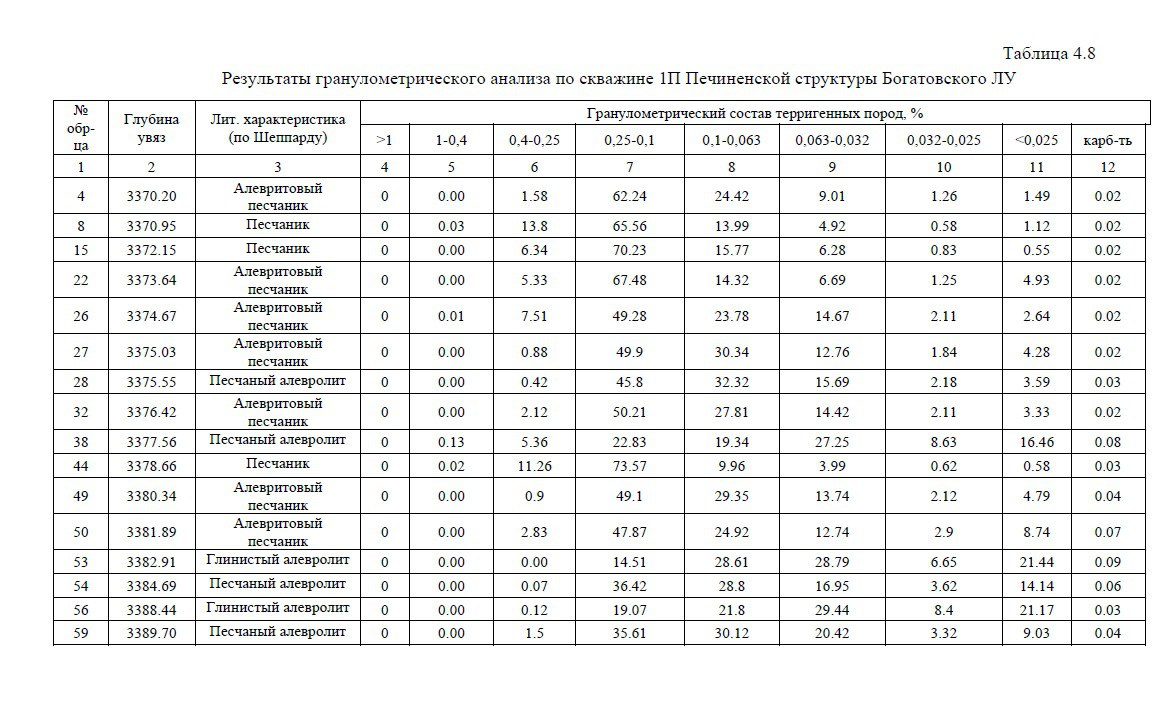